<h1 style="font-size:2rem;color:green;">English to Portuguese Translator LLM</h1>

## Set up PyTorch

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas
!pip install ipywidgets
!pip install widgetsnbextension
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Looking in indexes: https://download.pytorch.org/whl/cu118


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\joshu\anaconda3\Scripts\jupyter-contrib.EXE\__main__.py", line 7, in <module>
  File "C:\Users\joshu\anaconda3\Lib\site-packages\jupyter_core\application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "C:\Users\joshu\anaconda3\Lib\site-packages\traitlets\config\application.py", line 990, in launch_instance
    app = cls.instance(**kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\anaconda3\Lib\site-packages\traitlets\config\configurable.py", line 552, in instance
    inst = cls(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\anaconda3\Lib\site-packages\jupyter_contrib_core\application.py", line 27, in __init__
    self._refresh_subcommands()
  File "C:\Users\joshu\anaconda3\Lib\site-packages\jupyter_contrib_core\application.py", line 43, in _refresh_su

## 1. Import the necessary libraries and modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import pandas as pd

C:\Users\joshu\AppData\Local\Temp\ipykernel_324\547781205.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. Defining the basic building blocks: Multi-Head Attention, Position-wise Feed-Forward Networks, Positional Encoding

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            _MASKING_VALUE = -1e+30 if attn_scores.dtype == torch.float32 else -1e+4            
            attn_scores = attn_scores.masked_fill(mask == 0, value=_MASKING_VALUE)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position-wise Feed-Forward Networks

In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### Positional Encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        self.max_seq_length = max_seq_length  # Store max_seq_length explicitly
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # print(f'x size: {x.size()}')
        # print(f'self.pe size: {self.pe.size()}')
        return x + self.pe[:, :x.size(1)]

## 3. Building the Encoder Blocks

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## 4. Building the Decoder Blocks

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## 5. Combine the Encoder and Decoder layers to complete the Transformer network

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        # Ensure tgt_mask is on the same device as tgt
        #tgt_mask = tgt_mask.to(tgt.device)

        nopeak_mask = nopeak_mask.to(tgt.device)
        
        tgt_mask = tgt_mask & nopeak_mask
        
        tgt_on_cuda = tgt_mask.is_cuda
        nopeak_on_cuda = nopeak_mask.is_cuda
        
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
    
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
    
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

<h1 style="font-size:2rem;color:green;">Dataset Loading and Tokenization, and Model Training</h1>

# Import Libraries

In [70]:
!pip install torchtext==0.6.0 spacy numpy nltk scikit-learn tqdm matplotlib

In [72]:
import os
import torchtext
from torchtext.data import get_tokenizer, Field, TabularDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import nltk
nltk.download('punkt')
import spacy
spacy.cli.download("en_core_web_sm")
spacy.cli.download("pt_core_news_sm")
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


# Load English to Portuguese Translation Dataset

In [11]:
# Load English to Portuguese translation data
dataset_file_path = './por.txt'  # Adjust the path accordingly

# Load and preprocess translation data
df = pd.read_csv(dataset_file_path, sep='\t', header=None)[[0, 1]].rename(columns={0: 'EN', 1: 'PT'})

df.head()

,EN,PT
0,Go.,Vai.
1,Go.,Vá.
2,Hi.,Oi.
3,Run!,Corre!
4,Run!,Corra!


In [12]:
df.shape

(168903, 2)

In [13]:
# Shuffle the rows and reindex
df = df.sample(frac = 1).reset_index(drop=True)

df.head()

,EN,PT
0,Do you know any of them?,Você sabe de algum deles?
1,I think I can help.,Eu acho que posso ajudar.
2,It was a horrible scene.,Foi uma cena pavorosa.
3,You must study grammar more.,Você precisa estudar mais gramática.
4,I've noticed that Tom doesn't usually lock his...,Notei que Tom não costuma trancar sua porta.


In [14]:
df = df[:100000]

df.shape

(100000, 2)

In [15]:
# Add Extra Context for Tranformer
df['PT'] = df['PT'].apply(lambda x: "<SOS> " + x + " <EOS>")

df.head()

,EN,PT
0,Do you know any of them?,<SOS> Você sabe de algum deles? <EOS>
1,I think I can help.,<SOS> Eu acho que posso ajudar. <EOS>
2,It was a horrible scene.,<SOS> Foi uma cena pavorosa. <EOS>
3,You must study grammar more.,<SOS> Você precisa estudar mais gramática. <EOS>
4,I've noticed that Tom doesn't usually lock his...,<SOS> Notei que Tom não costuma trancar sua po...


# Preprocess/Tokenize Dataset

In [16]:
def eng_preprocess(text):
    text = text.lower()
    text = re.sub(re.compile(r'[^a-zA-Z0-9\s]'), '', text)
    text = nltk.word_tokenize(text)
    text = " ".join([i.strip() for i in text])
    return text


def pt_preprocess(text):
    text = text.replace("\u202f"," ")
    text = text.lower()
    text = re.sub(re.compile("[^a-zéâàçêêëôîû!?',]"), ' ', text)
    return text

In [17]:
df['EN'] = df['EN'].apply(lambda x: eng_preprocess(x))

df.head()

,EN,PT
0,do you know any of them,<SOS> Você sabe de algum deles? <EOS>
1,i think i can help,<SOS> Eu acho que posso ajudar. <EOS>
2,it was a horrible scene,<SOS> Foi uma cena pavorosa. <EOS>
3,you must study grammar more,<SOS> Você precisa estudar mais gramática. <EOS>
4,ive noticed that tom doesnt usually lock his door,<SOS> Notei que Tom não costuma trancar sua po...


In [18]:
df['PT'] = df['PT'].apply(lambda x: pt_preprocess(x))

df.head()

,EN,PT
0,do you know any of them,sos você sabe de algum deles? eos
1,i think i can help,sos eu acho que posso ajudar eos
2,it was a horrible scene,sos foi uma cena pavorosa eos
3,you must study grammar more,sos você precisa estudar mais gram tica eos
4,ive noticed that tom doesnt usually lock his door,sos notei que tom n o costuma trancar sua po...


# Tokenize Features and Targets

In [19]:
def feature_tokenization(feat):
    # Step 1: Create a tokenizer
    tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    # Step 2: Create a torchtext Field for English features
    eng_field = Field(tokenize=tokenizer, lower=True)

    # Step 3: Use the Field to process the feature text
    eng_field.build_vocab([eng_field.preprocess(f) for f in feat])

    # Step 4: Convert feature text to sequences
    eng_seq = [eng_field.numericalize([f]) for f in feat]

    # Step 5: Convert PyTorch tensors to Python lists
    eng_seq = [seq.squeeze().tolist() for seq in eng_seq]

    return eng_seq, eng_field

def target_tokenization(target):
    # Step 1: Create a tokenizer
    tokenizer = get_tokenizer("spacy", language="pt_core_news_sm")

    # Step 2: Create a torchtext Field for Portuguese targets
    port_field = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    # Step 3: Use the Field to process the target text
    port_field.build_vocab([port_field.preprocess(t) for t in target])

    # Step 4: Convert target text to sequences
    port_seq = [port_field.numericalize([t]) for t in target]

    # Step 5: Convert PyTorch tensors to Python lists
    port_seq = [seq.squeeze().tolist() for seq in port_seq]

    return port_seq, port_field

In [20]:
eng_sequences, eng_field = feature_tokenization(df['EN'])

In [21]:
eng_vocab = len(eng_field.vocab) + 1
eng_vocab

10864

In [22]:
eng_sequences[:5]

[[83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4990, 0, 0, 0, 0, 25],
 [2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2548, 10, 0, 0, 0, 0, 0, 9562],
 [2,
  0,
  0,
  0,
  10,
  34,
  0,
  10,
  0,
  0,
  0,
  0,
  0,
  2,
  4155,
  0,
  0,
  0,
  34,
  2548,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  25,
  0,
  34,
  0,
  0,
  34,
  0,
  0,
  83,
  0,
  0,
  0,
  0,
  10,
  25,
  25,
  10,
  0,
  0,
  25,
  0,
  0,
  0],
 [2,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2548,
  0,
  83,
  0,
  0,
  0,
  10,
  0,
  0,
  0,
  0,
  25,
  0,
  83,
  0,
  0,
  34,
  0,
  0,
  0,
  0,
  34,
  0,
  10,
  0,
  0,
  0,
  0,
  0,
  0,
  2548,
  0,
  0,
  0,
  2,
  34,
  0,
  83,
  0,
  0,
  0]]

In [23]:
port_sequences, port_field = target_tokenization(df['PT'])

In [24]:
port_vocab = len(port_field.vocab) + 1
port_vocab

16607

In [25]:
port_sequences[:5]

[[4,
  23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  23,
  15,
  1797,
  35,
  4,
  198,
  35,
  4,
  15,
  91,
  2033,
  3723,
  79,
  4,
  198,
  35,
  91,
  35,
  23,
  13,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  35,
  3723,
  4,
  15,
  412,
  82,
  8,
  4,
  0,
  3723,
  35,
  4,
  259,
  8,
  23,
  23,
  8,
  4,
  15,
  75,
  3723,
  198,
  15,
  224,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  234,
  8,
  1082,
  4,
  3723,
  79,
  15,
  4,
  412,
  35,
  10,
  15,
  4,
  259,
  15,
  127,
  8,
  224,
  8,
  23,
  15,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  259,
  224,
  35,
  412,
  1082,
  23,
  15,
  4,
  35,
  23,
  85,
  3723,
  198,
  15,
  224,
  4,
  79,
  15,
  1082,
  23,
  4,
  2033,
  224,
  15,
  79,
  4,
  85,
  1082,
  412,
  15,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  10,
  8,
  85,
  35,
  1082,
  4,
  0,
 

In [26]:
port_inp = [x[:-1] for x in port_sequences]
port_inp[:5]

[[4,
  23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  23,
  15,
  1797,
  35,
  4,
  198,
  35,
  4,
  15,
  91,
  2033,
  3723,
  79,
  4,
  198,
  35,
  91,
  35,
  23,
  13,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  35,
  3723,
  4,
  15,
  412,
  82,
  8,
  4,
  0,
  3723,
  35,
  4,
  259,
  8,
  23,
  23,
  8,
  4,
  15,
  75,
  3723,
  198,
  15,
  224,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  234,
  8,
  1082,
  4,
  3723,
  79,
  15,
  4,
  412,
  35,
  10,
  15,
  4,
  259,
  15,
  127,
  8,
  224,
  8,
  23,
  15,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  259,
  224,
  35,
  412,
  1082,
  23,
  15,
  4,
  35,
  23,
  85,
  3723,
  198,
  15,
  224,
  4,
  79,
  15,
  1082,
  23,
  4,
  2033,
  224,
  15,
  79,
  4,
  85,
  1082,
  412,
  15,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  10,
  8,
  85,
  35,
  1082,
  4,
  0,
  3723,
  35,
  4,
  

In [27]:
port_out = [x[1:] for x in port_sequences]
port_out[:5]

[[23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  23,
  15,
  1797,
  35,
  4,
  198,
  35,
  4,
  15,
  91,
  2033,
  3723,
  79,
  4,
  198,
  35,
  91,
  35,
  23,
  13,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  35,
  3723,
  4,
  15,
  412,
  82,
  8,
  4,
  0,
  3723,
  35,
  4,
  259,
  8,
  23,
  23,
  8,
  4,
  15,
  75,
  3723,
  198,
  15,
  224,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  234,
  8,
  1082,
  4,
  3723,
  79,
  15,
  4,
  412,
  35,
  10,
  15,
  4,
  259,
  15,
  127,
  8,
  224,
  8,
  23,
  15,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  127,
  8,
  412,
  0,
  4,
  259,
  224,
  35,
  412,
  1082,
  23,
  15,
  4,
  35,
  23,
  85,
  3723,
  198,
  15,
  224,
  4,
  79,
  15,
  1082,
  23,
  4,
  2033,
  224,
  15,
  79,
  4,
  85,
  1082,
  412,
  15,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  10,
  8,
  85,
  35,
  1082,
  4,
  0,
  3723,
  35,
  4,
  85,
 

# Pad Sequence

In [28]:
def pad_seq(pad):
    # Convert to PyTorch tensor
    pad_tensor = [torch.tensor(seq) for seq in pad]
    
    # Pad sequences using pad_sequence
    padded_seq = pad_sequence(pad_tensor, batch_first=True, padding_value=0)
    
    return padded_seq

In [29]:
encoder_input = pad_seq(eng_sequences)
encoder_input

tensor([[83,  0,  0,  ...,  0,  0,  0],
        [ 2,  0,  0,  ...,  0,  0,  0],
        [ 2,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 2,  0,  0,  ...,  0,  0,  0],
        [ 2, 34,  0,  ...,  0,  0,  0]])

In [30]:
encoder_input.shape

torch.Size([100000, 188])

In [31]:
decoder_input = pad_seq(port_inp)
decoder_input

tensor([[ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        ...,
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0]])

In [32]:
decoder_input.shape

torch.Size([100000, 195])

In [33]:
decoder_output = pad_seq(port_out)
decoder_output

tensor([[23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        ...,
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0]])

In [34]:
decoder_output.shape

torch.Size([100000, 195])

In [78]:
assert not torch.isnan(encoder_input).any()
assert not torch.isnan(decoder_input).any()

# Training the PyTorch Transformer Model

In [35]:
# Hyperparameters
src_vocab_size = eng_vocab
tgt_vocab_size = port_vocab
batch_size = 64
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 1024 #prev 2048
max_seq_len = max(encoder_input.size(1), decoder_input.size(1))
dropout = 0.1
epoch = None

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device: {device}")

# Sequence Length
src_seq_len = encoder_input.shape[1]
tgt_seq_len = decoder_input.shape[1]

# Src and tgt datasets
src_data = encoder_input
tgt_data = decoder_input

# Create an instance of the Transformer model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout)

# Move model and data to the selected device
transformer.to(device)
#src_data, tgt_data = src_data.to(device), tgt_data.to(device)

# Print the device on which the model parameters are located
print(f"Model parameters device: {next(transformer.parameters()).device}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Create ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

# Scaler
scaler = GradScaler()

Current device: cuda
Model parameters device: cuda:0


## Prepare Training and Validation Splits, and DataLoaders

In [36]:
# Split the data into training and validation sets
train_src_data, val_src_data, train_tgt_data, val_tgt_data = train_test_split(
    src_data, tgt_data, test_size=0.2, random_state=42
)

In [37]:
# Assuming you have a custom dataset class, let's call it MyDataset
class MyDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample = self.src_data[idx].to(device)
        tgt_sample = self.tgt_data[idx].to(device)
        return src_sample, tgt_sample

In [38]:
# Create an instance of your dataset
train_dataset = MyDataset(train_src_data, train_tgt_data)

# Create a DataLoader for training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
# Create an instance of your validation dataset
val_dataset = MyDataset(val_src_data, val_tgt_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Compute Accuracy Function

In [40]:
def compute_accuracy(output, target):
    """
    Compute accuracy based on the model's output and target values.

    Args:
    - output (torch.Tensor): Model's output tensor.
    - target (torch.Tensor): Target tensor.

    Returns:
    - accuracy (float): Accuracy value.
    """
    # Assuming output and target are tensors
    # Get the predicted indices with maximum probability
    _, predicted = torch.max(output, dim=2)

    # Mask for valid positions (non-padding)
    mask = (target != 0).float()

    # Compare predicted and target values, count correct predictions
    correct = (predicted == target) * mask

    # Calculate accuracy
    accuracy = correct.sum().item() / mask.sum().item() if mask.sum().item() > 0 else 0.0

    return accuracy

## Create/Load Checkpoints and Training Progress

In [41]:
# File path for the saved checkpoint
checkpoint_file_path = './checkpoint.pth'

# Check if the file exists
if os.path.exists(checkpoint_file_path):
    # Load the saved checkpoint
    checkpoint = torch.load(checkpoint_file_path)

    # Load epoch
    epoch = checkpoint['epoch']

    # Load transformer
    transformer_checkpoint = checkpoint['model_state_dict']
    keys_to_load = ['encoder_embedding', 'decoder_embedding', 'positional_encoding', 
                    'encoder_layers', 'decoder_layers', 'fc']
    filtered_state_dict = {k: v for k, v in transformer_checkpoint.items() if k in keys_to_load}
    transformer.load_state_dict(filtered_state_dict, strict=False)
    #transformer.load_state_dict(checkpoint['model_state_dict'])

    # Load the optimizer state dict
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load Scheduler
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Load Scaler
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    print("Checkpoint loaded successfully")

else:
    # If the file doesn't exist, create and save checkpoint
    epoch = 0
    torch.save({
    'epoch': epoch,
    'model_state_dict': transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    }, checkpoint_file_path)
    print("Checkpoint file not found. Initial checkpoint created and saved.")

Checkpoint loaded successfully


In [42]:
# File path for the saved checkpoint
progress_file_path = './training_progress.pth'
training_progress = None

# Check if the file exists
if os.path.exists(progress_file_path):
    # Load the saved checkpoint
    print("Training progress loaded successfully")
    training_progress = torch.load(progress_file_path)

    print("Information in the training progress:")
    for epoch_info in training_progress:
        print(f"Epoch: {epoch_info['epoch']}, "
              f"Avg Loss: {epoch_info['avg_loss']:.4f}, "
              f"Avg Accuracy: {epoch_info['avg_accuracy']:.4f}, "
              f"Avg Val Loss: {epoch_info['avg_val_loss']:.4f}, "
              f"Avg Val Accuracy: {epoch_info['avg_val_accuracy']:.4f}, "
              f"Learning Rate: {epoch_info['learning_rate']:.4f}")


else:
    # If the file doesn't exist, create and save training progress
    training_progress = []
    torch.save(training_progress, progress_file_path)
    print("Training progress file not found. File created and saved.")

Training progress loaded successfully
Information in the training progress:
Epoch: 1, Avg Loss: 1.4146, Avg Accuracy: 0.5892, Avg Val Loss: 1.0164, Avg Val Accuracy: 0.6875, Learning Rate: 0.0001
Epoch: 2, Avg Loss: 0.9134, Avg Accuracy: 0.7185, Avg Val Loss: 0.8416, Avg Val Accuracy: 0.7402, Learning Rate: 0.0001
Epoch: 3, Avg Loss: 0.7887, Avg Accuracy: 0.7567, Avg Val Loss: 0.7653, Avg Val Accuracy: 0.7644, Learning Rate: 0.0001
Epoch: 4, Avg Loss: 0.7288, Avg Accuracy: 0.7749, Avg Val Loss: 0.7427, Avg Val Accuracy: 0.7711, Learning Rate: 0.0001
Epoch: 5, Avg Loss: nan, Avg Accuracy: 0.0003, Avg Val Loss: nan, Avg Val Accuracy: 0.0000, Learning Rate: 0.0001
Epoch: 6, Avg Loss: nan, Avg Accuracy: 0.0000, Avg Val Loss: nan, Avg Val Accuracy: 0.0000, Learning Rate: 0.0001


In [43]:
# Set the model to evaluation mode
transformer.eval()

Transformer(
  (encoder_embedding): Embedding(10864, 512)
  (decoder_embedding): Embedding(16607, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(

# Training the Model

In [44]:
# Training loop
transformer.train()

for current_epoch in range(epoch, 100):
    epoch = current_epoch
    total_loss = 0.0
    total_accuracy = 0.0
    total_val_loss = 0.0
    total_val_accuracy = 0.0
    
    print(f"Starting Epoch: {epoch+1}")
    optimizer.zero_grad()

    # Run 
    for train_batch_idx, (train_src_batch, train_tgt_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/100, Training Set", position=0, ncols=240), start=1):
        with autocast():
            # Forward Pass
            output = transformer(train_src_batch, train_tgt_batch[:, :-1])

            # Compute the loss using normalized outputs
            loss = criterion(output.contiguous().view(-1, tgt_vocab_size), train_tgt_batch[:, 1:].contiguous().view(-1))

        # Backward Pass
        scaler.scale(loss).backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1)

        # Update Optimizer
        scaler.step(optimizer)
        scaler.update()

        # Accumulate total validation loss
        total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        
        # Compute accuracy
        train_accuracy = compute_accuracy(output, train_tgt_batch[:, 1:])
        total_accuracy += train_accuracy
        avg_accuracy = total_accuracy / len(train_dataloader)
        
        # Print progress
        if train_batch_idx % 25 == 0:  # Print every 25 batches
            print(f"Epoch: {epoch+1}/100, Train Batch: {train_batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

    print(f"Train_Batch for Epoch {epoch+1} completed. Avg_Loss: {avg_loss:.4f}, Avg_Accuracy: {avg_accuracy:.4f}")

    
    for val_batch_idx, (val_src_batch, val_tgt_batch) in enumerate(tqdm(val_dataloader, desc=f"Epoch {epoch+1}/100, Validation Set", position=0, ncols=240), start=1):
        with torch.no_grad():
            val_output = transformer(val_src_batch, val_tgt_batch[:, :-1])
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_batch[:, 1:].contiguous().view(-1))

        # Calculate average validation loss
        total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        
        # Compute accuracy
        val_accuracy = compute_accuracy(val_output, val_tgt_batch[:, 1:])
        total_val_accuracy += val_accuracy
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        
        # Print progress
        if val_batch_idx % 25 == 0:  # Print every 25 batches (adjust as needed)
            print(f"Epoch: {epoch+1}/100, Val_Batch: {val_batch_idx}/{len(val_dataloader)}, Val_Loss: {val_loss.item():.4f}, Val_Accuracy: {val_accuracy:.4f}")

    print(f"Val_Batch for Epoch {epoch+1} completed. Avg_Val_Loss: {avg_val_loss:.4f}, Avg_Val_Accuracy: {avg_val_accuracy:.4f}")
    
    # Update scheduler based on validation loss
    scheduler.step(avg_val_loss)
    
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
    }, checkpoint_file_path)
    print(f"Model, Optimizer, Scheduler, and Scaler states for Epoch {epoch+1} updated and saved.")
    
    print(f"Epoch {epoch+1} Complete, Avg_Loss: {avg_loss:.4f}, Avg_Accuracy: {avg_accuracy:.4f}, Avg_Val_Loss: {avg_val_loss:.4f}, Avg_Val_Accuracy: {avg_val_accuracy:.4f}")

    current_learning_rate = optimizer.param_groups[0]['lr']
    
    # Save training progress (average loss and average accuracy)
    training_progress.append({
        'epoch': epoch + 1,
        'avg_loss': avg_loss,
        'avg_accuracy': avg_accuracy,
        'avg_val_loss': avg_val_loss,
        'avg_val_accuracy': avg_val_accuracy,
        'learning_rate': current_learning_rate
    })

    print(f"Learning Rate: {current_learning_rate:.8f}")

    # Save the updated training progress
    torch.save(training_progress, progress_file_path)
    print(f"Training progress updated and saved.")

    # Check for early stopping using scheduler metrics
    if scheduler.num_bad_epochs > scheduler.patience:
        print("Early stopping triggered.")
        break

Starting Epoch: 7


Epoch 7/100, Training Set:   0%|                                                                              …

RuntimeError: The size of tensor a (10801) must match the size of tensor b (10864) at non-singleton dimension 0

# Plot a Graph with the info of training progress

In [75]:
def plot_training_progress(training_progress):
    epochs = [entry['epoch'] for entry in training_progress]
    avg_loss = [entry['avg_loss'] for entry in training_progress]
    avg_accuracy = [entry['avg_accuracy'] for entry in training_progress]
    avg_val_loss = [entry['avg_val_loss'] for entry in training_progress]
    avg_val_accuracy = [entry['avg_val_accuracy'] for entry in training_progress]
    learning_rate = [entry['learning_rate'] for entry in training_progress]

    # Plotting Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, avg_loss, label='Training Loss')
    plt.plot(epochs, avg_val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, avg_accuracy, label='Training Accuracy')
    plt.plot(epochs, avg_val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Plotting Learning Rate
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, learning_rate, label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()


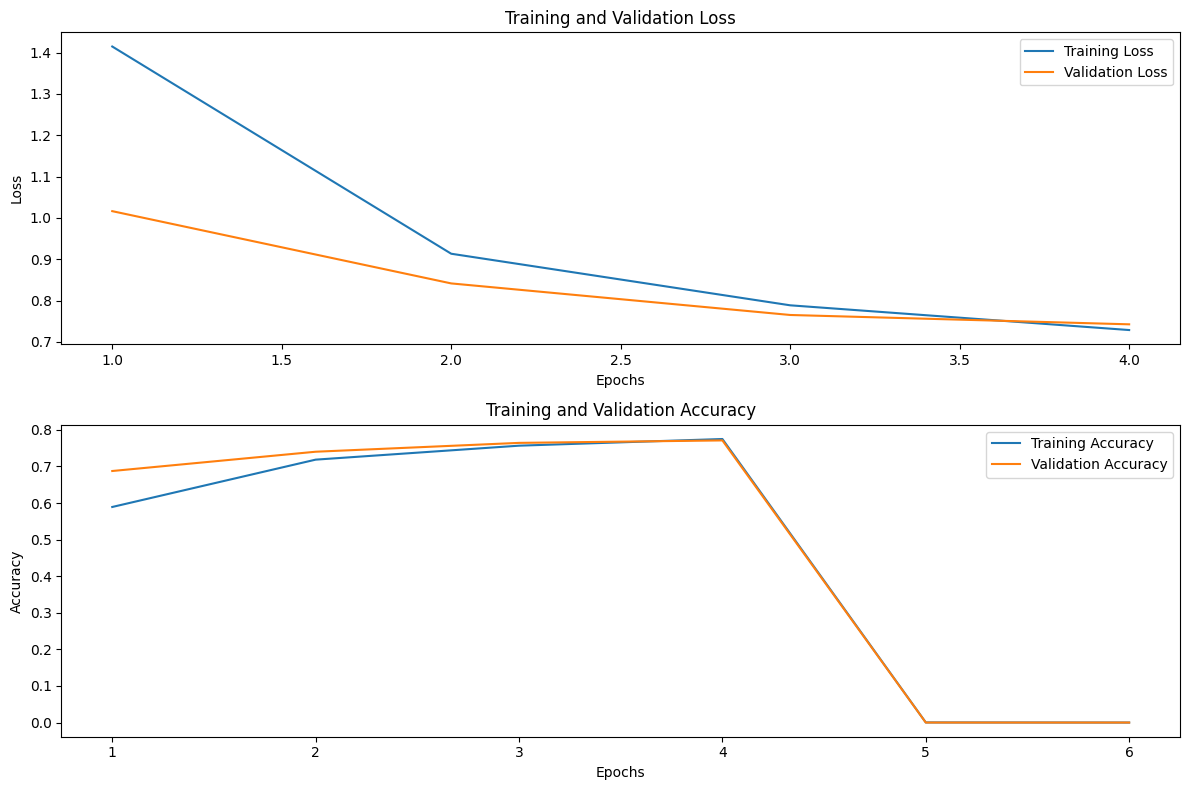

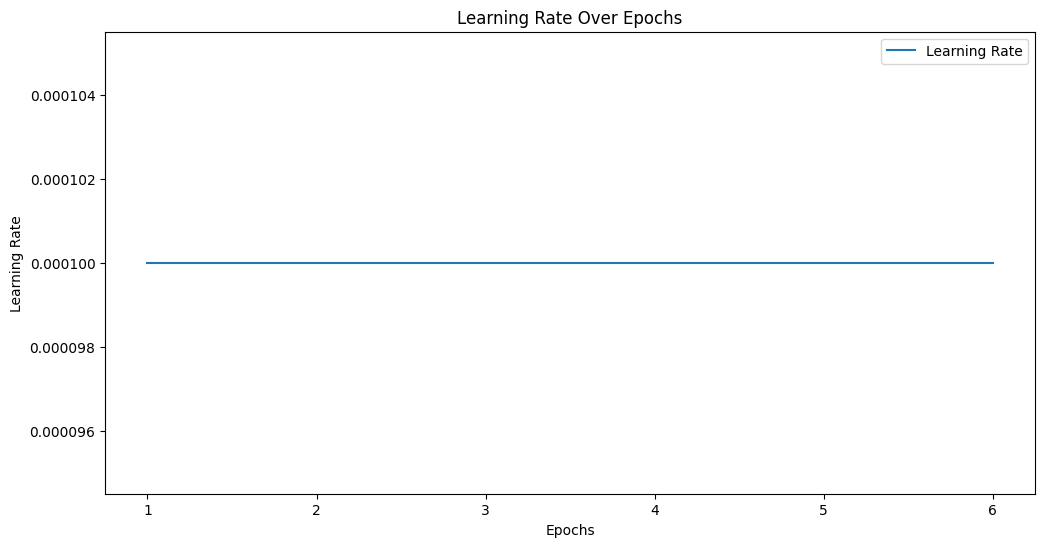

In [76]:
# Call the function to plot the training progress
plot_training_progress(training_progress)

# Prepare Inputs, Decode, and Translate

In [64]:
def prepare_inputs(sentences):
    input_tokenized = eng_field.numericalize([sentences])
    input_padded = pad_sequence(input_tokenized, batch_first=True, padding_value=0)
    
    # Truncate or zero-pad to the specified maxlen
    if input_padded.size(1) > src_seq_len:
        input_padded = input_padded[:, :src_seq_len]
    else:
        input_padded = F.pad(input_padded, (0, src_seq_len - input_padded.size(1)))
    
    input_tensor = torch.tensor(input_padded, dtype=torch.long)
    
    return input_tensor

In [65]:
def decode_process(d):
    target_tokenized = port_field.numericalize([d])
    target_padded = pad_sequence(target_tokenized, batch_first=True, padding_value=0)
    
    # Truncate or zero-pad to the specified maxlen
    if target_padded.size(1) > tgt_seq_len:
        target_padded = target_padded[:, :tgt_seq_len]
    else:
        target_padded = F.pad(target_padded, (0, tgt_seq_len - target_padded.size(1)))
    
    dt = torch.tensor(target_padded, dtype=torch.long)
    
    return dt

In [66]:
decoder_end = ["<EOS>"]
end = port_field.numericalize([decoder_end])
end = end[0].clone().detach()
end

tensor([0])

In [67]:
def translate(inputs):
    # Set the model to evaluation mode
    transformer.eval()
    
    # Prepare input tensor
    tt = prepare_inputs(inputs)
    
    # Initialize the target input with "<SOS>"
    d = ["<sos>"]

    # Numericalize the target input
    dt = decode_process(d)

    # Move tensors to the appropriate device (GPU if available)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tt = tt.to(device)
    dt = dt.to(device)
    
    # Generate translations
    with torch.no_grad():
        for i in tqdm(range(tgt_seq_len), desc="Generating Translations", position=0, ncols=240):
            # Forward pass
            output = transformer(tt, dt)

            # Get the indices of the predicted tokens at the last position
            pred_indices = torch.argmax(output[:, -1, :], dim=-1)

            # Extract the predicted tokens as a list
            pred_tokens = [port_field.vocab.itos[index.item()] for index in pred_indices]

            # Append the predicted tokens to the target sequence
            d.extend(pred_tokens)

            # Stop if <EOS> is predicted
            if (pred_indices == port_field.vocab.stoi[end]).any():
                break
            
            # Update the target input tensor for the next step
            dt = torch.cat([dt, pred_indices.unsqueeze(0)], dim=-1)
            
            # Enforce max_seq_length by keeping the last max_seq_length elements
            dt = dt[:, -max_seq_len:]

    # Convert the generated translation back to a string
    translation = " ".join(d)

    return translation

In [77]:
for i in range(5):
    print("English Sentence : ", df['EN'][i])
    print("Original Portugal Sentence : ", df['PT'][i])
    print("Predicted Sentence : ", translate(df["EN"][i]))
    print("*" * 50)

English Sentence :  do you know any of them
Original Portugal Sentence :   sos  você sabe de algum deles?  eos 


C:\Users\joshu\AppData\Local\Temp\ipykernel_324\1569868288.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_padded, dtype=torch.long)


Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> fibras planeje planeje planeje planeje planeje planeje planeje planeje planeje planeje planeje gênio planeje planeje planeje planeje depress planeje planeje planeje planeje yukio partilhe repentina repentina repentina repentina repentina repentina repentina repentina repentina repentina repentina normalizar repentina repentina repentina repentina arrotei repentina repentina repentina repentina detestasse frustrar supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo supérfluo focas supérfluo supérfluo supérfluo supérfluo arrotei supérfluo supérfluo supérfluo supérfluo japonês frustrar dezessete dezessete dezessete dezessete dezessete dezessete dezessete dezessete dezessete dezessete dezessete antibi dezessete dezessete dezessete dezessete exagero dezessete dezessete dezessete dezessete assassinado lembro ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas restos ervi

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> limonada planeje planeje planeje limonada planeje planeje planeje limonada planeje chopin gênio planeje planeje planeje planeje planeje planeje correspondência enfrentaram enfrentaram enfrentaram correspondência enfrentaram enfrentaram enfrentaram correspondência enfrentaram chopin daltônica enfrentaram enfrentaram enfrentaram enfrentaram enfrentaram planeje correspondência enfrentaram enfrentaram enfrentaram correspondência enfrentaram enfrentaram enfrentaram correspondência enfrentaram chopin daltônica enfrentaram enfrentaram enfrentaram enfrentaram enfrentaram quebrou crendo ervilhas ervilhas ervilhas crendo ervilhas ervilhas ervilhas crendo ervilhas chopin receitou ervilhas ervilhas ervilhas ervilhas ervilhas contornar sobressai arrotei arrotei arrotei sobressai arrotei arrotei arrotei sobressai arrotei chopin museus arrotei arrotei arrotei arrotei arrotei recordar galinheiro festejado festejado festejado galinheiro festejado festejado festejado galinhei

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> limonada planeje planeje planeje gênio depress planeje gênio planeje planeje planeje planeje planeje limonada pretende planeje planeje planeje depress chopin planeje planeje planeje correspondência enfrentaram enfrentaram enfrentaram daltônica resolvê enfrentaram daltônica enfrentaram enfrentaram enfrentaram enfrentaram enfrentaram correspondência afinando enfrentaram enfrentaram enfrentaram resolvê chopin enfrentaram enfrentaram enfrentaram morreu planeje planeje planeje calar lidar planeje calar planeje planeje planeje planeje planeje morreu afinando planeje planeje planeje lidar assassinado planeje planeje planeje correspondência ervilhas ervilhas ervilhas daltônica resolvê ervilhas daltônica ervilhas ervilhas ervilhas ervilhas ervilhas correspondência afinando ervilhas ervilhas ervilhas resolvê chopin ervilhas ervilhas ervilhas museus repentina repentina repentina restos comecei repentina restos repentina repentina repentina repentina repentina museus es

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> planeje planeje planeje planeje yukio planeje depress planeje planeje depress planeje planeje fibras planeje planeje planeje planeje gênio yukio yukio gênio planeje planeje yukio planeje planeje planeje enfrentaram enfrentaram enfrentaram enfrentaram tecnicamente enfrentaram resolvê enfrentaram enfrentaram resolvê enfrentaram enfrentaram quebrou enfrentaram enfrentaram enfrentaram enfrentaram daltônica tecnicamente tecnicamente daltônica enfrentaram enfrentaram tecnicamente enfrentaram enfrentaram enfrentaram planeje planeje planeje planeje tecnicamente planeje lidar planeje planeje lidar planeje planeje detestasse planeje planeje planeje planeje calar tecnicamente tecnicamente calar planeje planeje tecnicamente planeje planeje planeje ervilhas ervilhas ervilhas ervilhas tecnicamente ervilhas resolvê ervilhas ervilhas resolvê ervilhas ervilhas quebrou ervilhas ervilhas ervilhas ervilhas daltônica tecnicamente tecnicamente daltônica ervilhas ervilhas tecnicam

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> limonada planeje planeje planeje planeje planeje planeje limonada chopin planeje fibras planeje planeje planeje gênio planeje planeje planeje planeje yukio planeje fibras planeje planeje depress planeje planeje planeje planeje depress planeje gênio planeje planeje planeje planeje planeje planeje chopin planeje planeje planeje limonada depress planeje fibras planeje planeje planeje correspondência ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas correspondência chopin ervilhas quebrou ervilhas ervilhas ervilhas daltônica ervilhas ervilhas ervilhas ervilhas tecnicamente ervilhas quebrou ervilhas ervilhas resolvê ervilhas ervilhas ervilhas ervilhas resolvê ervilhas daltônica ervilhas ervilhas ervilhas ervilhas ervilhas ervilhas chopin ervilhas ervilhas ervilhas correspondência resolvê ervilhas quebrou ervilhas ervilhas ervilhas crendo cobertas cobertas cobertas cobertas cobertas cobertas crendo assassinado cobertas detestasse cobertas cobertas cobertas res

In [ ]:
#-------------------------------------------------------------------

# Test Sample Texts

In [ ]:
translate("The weather is beautiful today.")

In [ ]:
translate("I enjoy reading books in my free time.")

In [ ]:
translate("Here is the nearest coffee shop?")

In [ ]:
translate("Learning new languages broadens your perspective.")

In [ ]:
translate("Can you recommend a good restaurant in the area?")

# Input Text and Get Translations

In [ ]:
def translate_input():
    while True:
        # Get user input
        user_input = input("Enter an English sentence (type 'exit' to quit): ")

        # Check if the user wants to exit
        if user_input.lower() == 'exit':
            print("Exiting translation program.")
            break

        # Use your existing translate function
        translation = translate(user_input)

        # Display the translation
        print(f"Translation: {translation}\n")

# Call The Translation Function

In [ ]:
translate_input()